In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,concatenate,UpSampling2D,Dropout,Input,Activation
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Unet like architecture proposed

In [8]:
def Unet(input_size):
    """encoder"""
    #block 1 
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation= 'relu')(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation= 'relu')(conv1)
  
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    #block 2
    conv2 = Conv2D(64,(3,3),padding="same",activation= 'relu')(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation= 'relu')(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    #block 3
    conv3  = Conv2D(128,(3,3),padding="same",activation= 'relu')(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation= 'relu')(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    #block 4
    conv4  = Conv2D(256,(3,3),padding="same",activation= 'relu')(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation= 'relu')(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    #block 5
    conv5  = Conv2D(512,(3,3),padding="same",activation= 'relu')(pool4)
    conv5  = Conv2D(512,(3,3),padding="same",activation= 'relu')(conv5)

    
    """decoder"""
    #block 1
    up1 =UpSampling2D((2,2))(conv5)
    merg1 =  concatenate([up1,conv4])
    dconv1  = Conv2D(256,(3,3),padding="same",activation= 'relu')(merg1)
    dconv1  = Conv2D(256,(3,3),padding="same",activation= 'relu')(dconv1)
    #block 2
    up2 =UpSampling2D((2,2))(dconv1)
    merg2 =  concatenate([up2,conv3])
    dconv2  = Conv2D(128,(3,3),padding="same",activation= 'relu')(merg2)
    dconv2  = Conv2D(128,(3,3),padding="same",activation= 'relu')(dconv2)
    
    #block 3
    up3 =UpSampling2D((2,2))(dconv2)
    merg3 =  concatenate([up3,conv2])
    dconv3  = Conv2D(64,(3,3),padding="same",activation= 'relu')(merg3)
    dconv3  = Conv2D(64,(3,3),padding="same",activation= 'relu')(dconv3)
    #block 4
    up4 =UpSampling2D((2,2))(dconv3)
    merg4 =  concatenate([up4,conv1])
    dconv4  = Conv2D(32,(3,3),padding="same",activation= 'relu')(merg4)
    dconv4  = Conv2D(32,(3,3),padding="same",activation= 'relu')(dconv4)

    out_put = Conv2D(1,1,padding ='same',activation= 'sigmoid')(dconv4)
    model = tf.keras.Model(input_scan,out_put,name='U_net')
    return model

In [9]:
model = Unet((512,512,1))

In [10]:
model.summary()

Model: "U_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 512, 512, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_33[0][0]']              
                                )                                                             

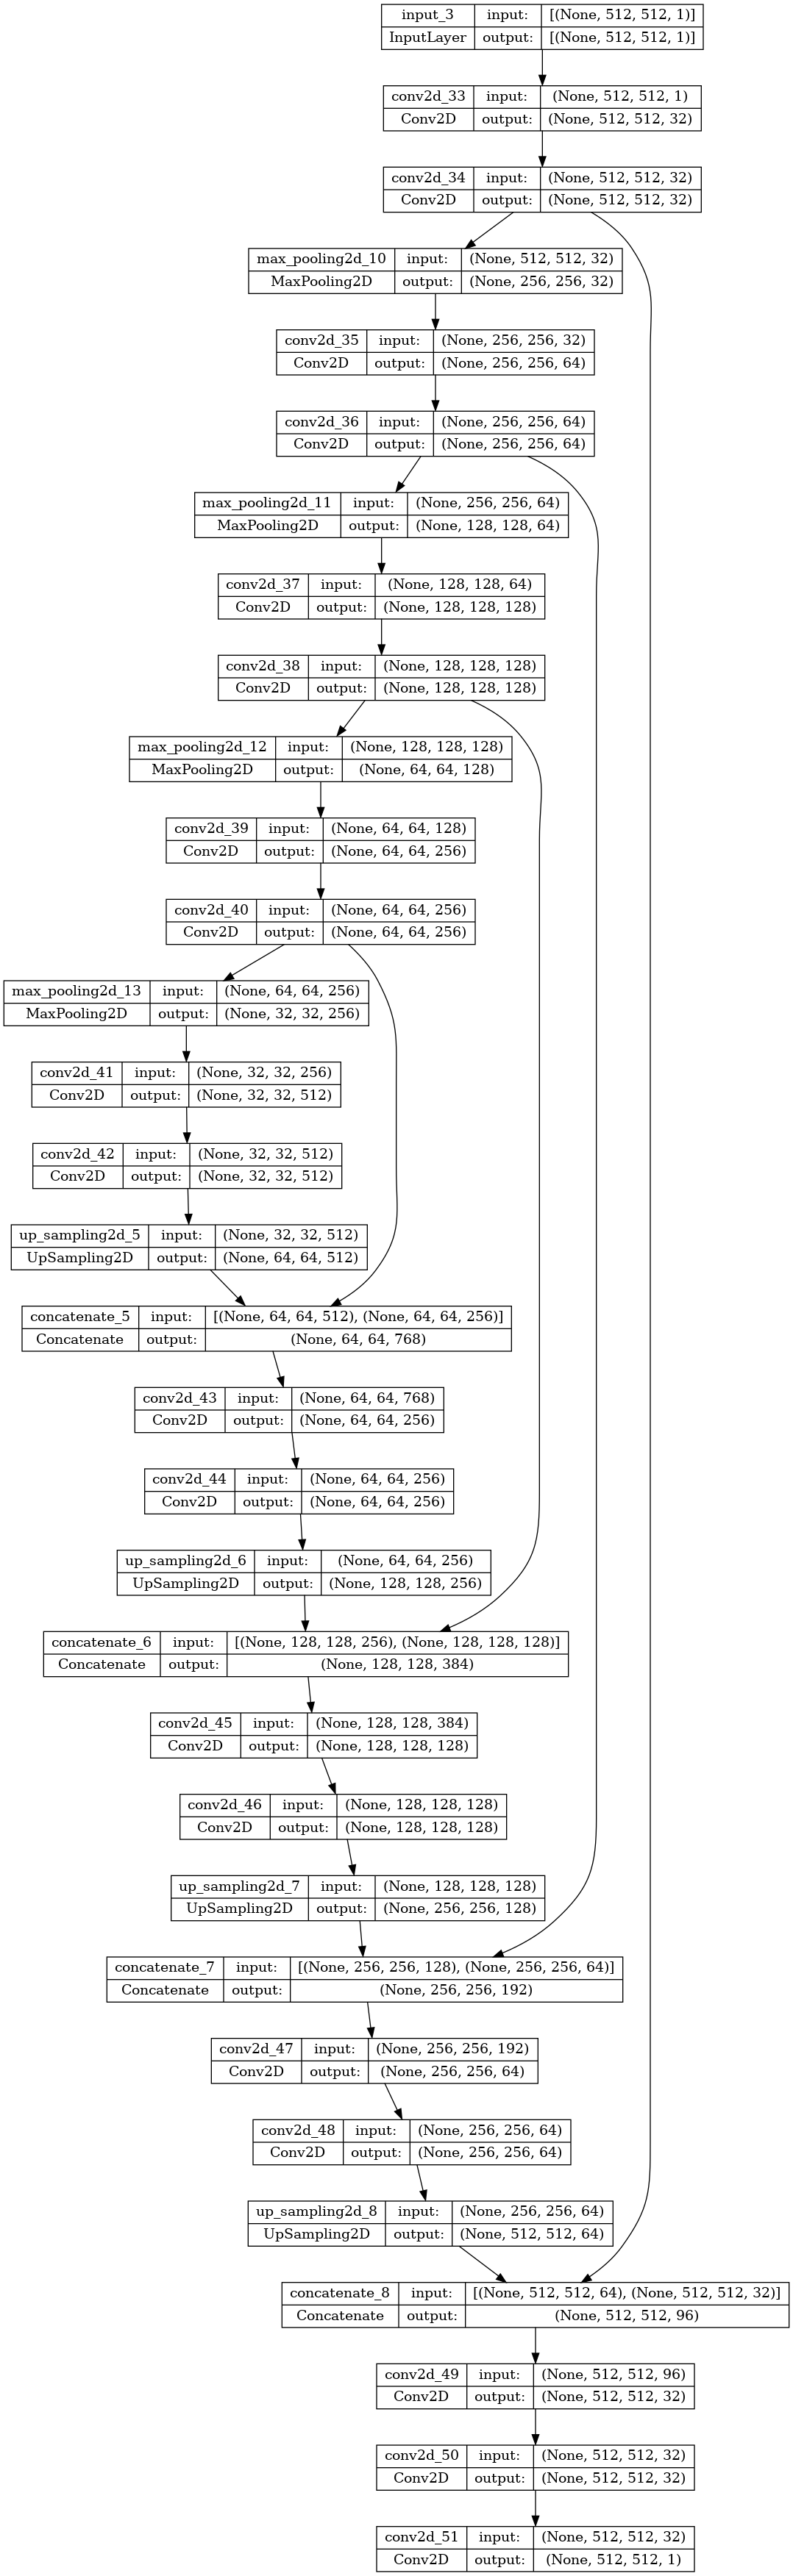

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [12]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [13]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [14]:
X = X/255

In [15]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.20,random_state=48)

In [16]:
from tensorflow.keras.layers import Flatten
def iou_coeff(y_true, y_pred):
    intersection = 0 
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection =  (2.*(y_true_f * y_pred_f) + tf.keras.backend.epsilon())
    union = (y_true_f + y_pred_f + tf.keras.backend.epsilon())
    return (intersection/union)

In [17]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=["accuracy",iou_coeff])

In [18]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=16,validation_split=0.20)

Epoch 1/50
59/59 [==============================] - 68s 840ms/step - loss: 0.1185 - accuracy: 0.9996 - iou_coeff: 0.5313 - val_loss: 0.0080 - val_accuracy: 0.9995 - val_iou_coeff: 0.0242
Epoch 2/50
59/59 [==============================] - 36s 610ms/step - loss: 0.0041 - accuracy: 0.9996 - iou_coeff: 0.1640 - val_loss: 0.0039 - val_accuracy: 0.9995 - val_iou_coeff: 0.2977
Epoch 3/50
59/59 [==============================] - 36s 606ms/step - loss: 0.0035 - accuracy: 0.9996 - iou_coeff: 0.2902 - val_loss: 0.0041 - val_accuracy: 0.9995 - val_iou_coeff: 0.2943
Epoch 4/50
59/59 [==============================] - 36s 606ms/step - loss: 0.0034 - accuracy: 0.9996 - iou_coeff: 0.3011 - val_loss: 0.0039 - val_accuracy: 0.9995 - val_iou_coeff: 0.2851
Epoch 5/50
59/59 [==============================] - 36s 610ms/step - loss: 0.0035 - accuracy: 0.9996 - iou_coeff: 0.3173 - val_loss: 0.0038 - val_accuracy: 0.9995 - val_iou_coeff: 0.2863
Epoch 6/50
59/59 [==============================] - 36s 610ms/ste

In [19]:
X1 = 0
X0 =0
Y1=0
Y0 = 0
X =0
Y=0

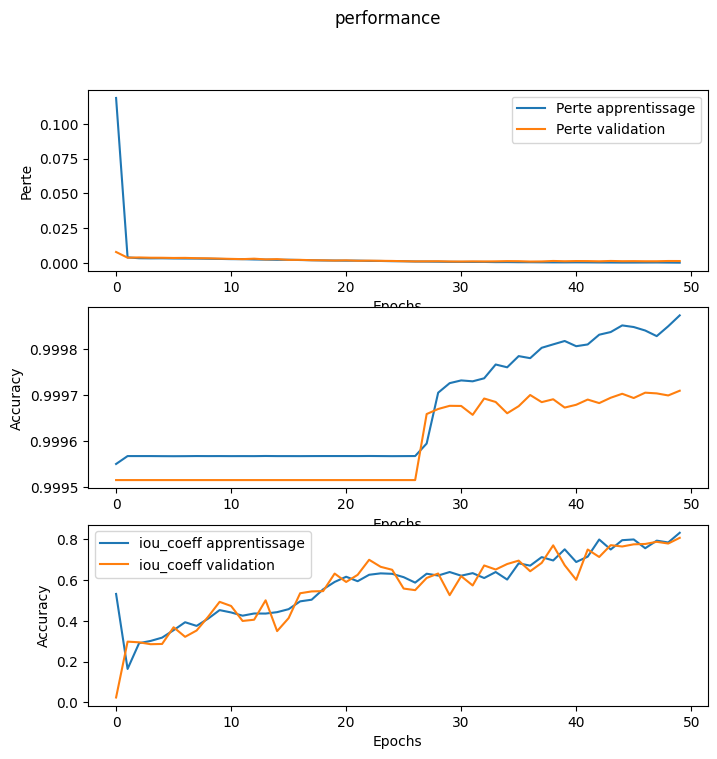

In [20]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(3, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte")
plt.legend() 
plt.subplot(3, 1, 2)
plt.plot(np.arange(0, 50), hist.history["accuracy"], label="Accuracy apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_accuracy"], label="Accuracy validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.subplot(3, 1, 3)
plt.plot(np.arange(0, 50), hist.history["iou_coeff"], label="iou_coeff apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_iou_coeff"], label="iou_coeff validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()

plt.legend()


In [21]:
model.evaluate(Xtest,Ytest)

10/10 [==============================] - 13s 509ms/step - loss: 0.0019 - accuracy: 0.9997 - iou_coeff: 0.8089


[0.0019015942234545946, 0.999667763710022, 0.8088808655738831]

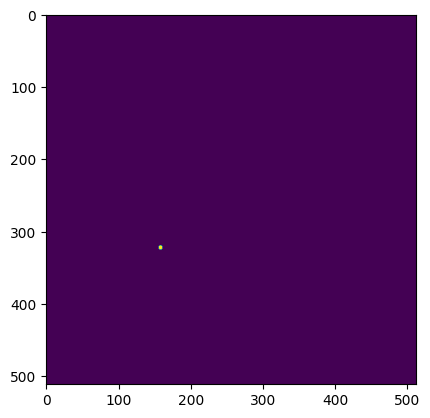

In [22]:
plt.imshow(Ytest[5])

In [23]:
#X = np.load("/kaggle/input/data12/X0.npy")
#X = X/255

y_1 = model.predict(Xtest[5].reshape((1,512,512, 1)))


1/1 [==============================] - 1s 860ms/step


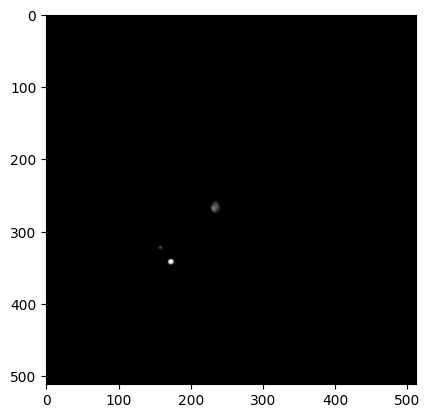

In [24]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [25]:
y_1.max()

0.9414837

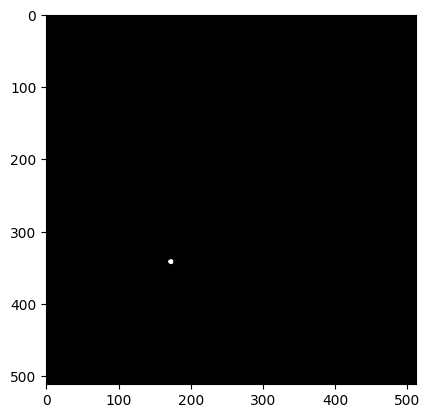

In [26]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [27]:

norm_img = Xtest[5].reshape((512,512))
img = norm_img * 255

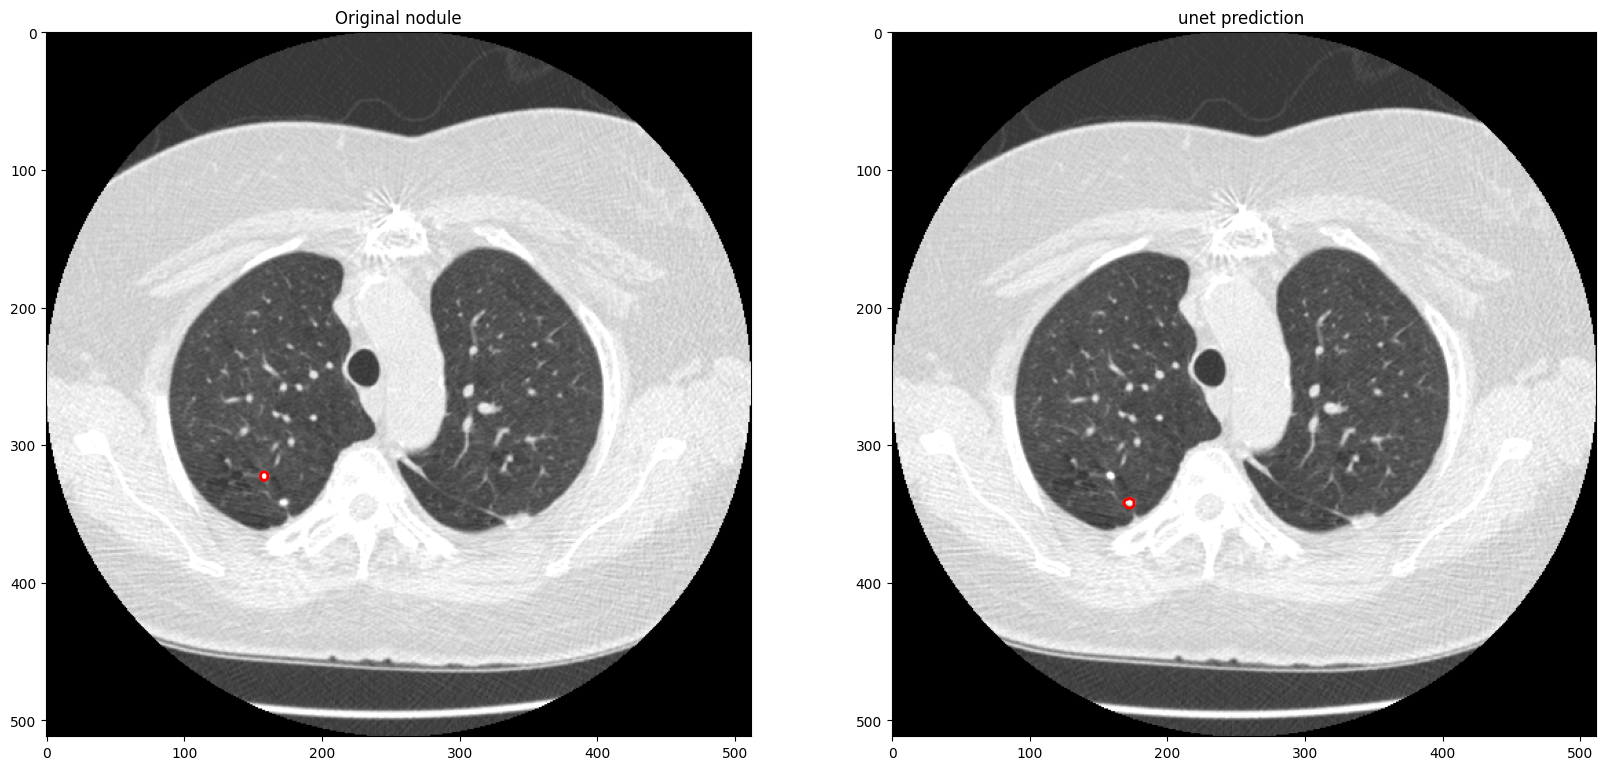

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('unet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[5].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [29]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(Ytest[5].reshape((512,512)), 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (158.0, 322.5)
Diameter: 5.664991855621338


In [30]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(y_1.reshape((512,512)), 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (172.24684143066406, 342.05511474609375)
Diameter: 7.114070892333984


In [ ]:
model.save("model")